# Define the Problem
- background: Popularity bias occurs because items with higher interaction frequencies (e.g., clicks, views) are over-represented, leading to skewed predictions.

- Aim: Separate the true causal effect of item features (relevance) from spurious correlations caused by popularity.

# Causal Inference Principles
To address popularity bias, use the following causal inference concepts:

1. **Confounding Variable**: Popularity acts as a confounder, influencing both the exposure of items and user interactions.
2. **Intervention**: Simulate a scenario where popularity is controlled or neutralized.
3. **Counterfactual Reasoning**: Predict user-item interactions in a world where the popularity bias is removed.

# Framework

## A. Causal Graph Modeling:

Incorporate a causal graph to explicitly model relationships:
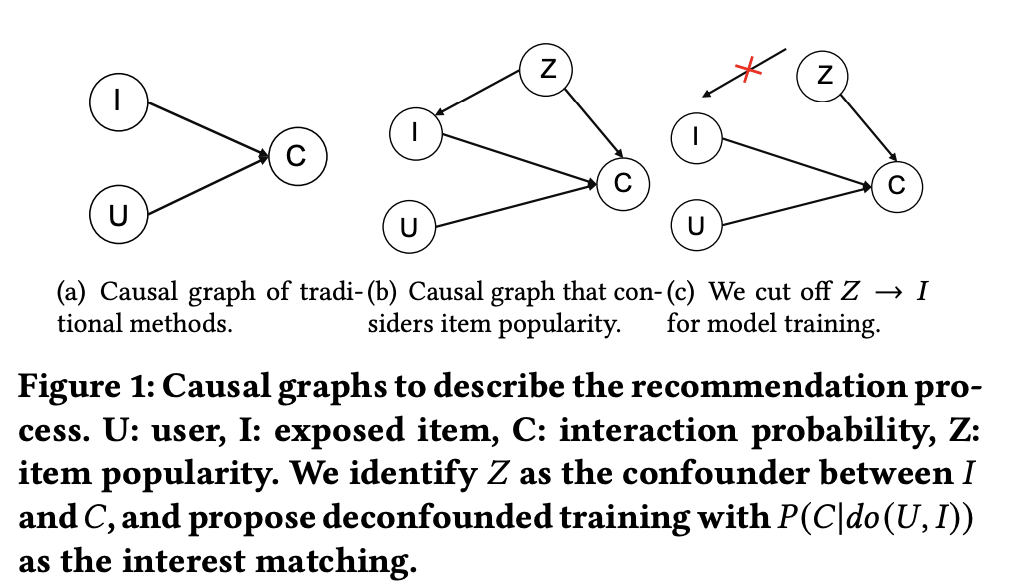
Use do-calculus or causal disentanglement to account for the confounding effect of item popularity.

- Aim: $P(C, do(U, I))$
- Backdoor Adjustment：来干预Exposed Item X不受popularity Z影响
  $$
  P(C, do(U, I)) = \sum_{z} 𝑃 (𝐶 |𝑈 , 𝐼, 𝑧) P(z)
  $$
- Assume: $𝑃 (𝐶 |𝑈 , 𝐼, 𝑧) =  𝑓 (𝑢, 𝑖) \cdot 𝑧$
- 推导结果: 
  $$P(C, do(U, I)) = f(u, i ) \cdot E(Z) $$
  所以我们要在模型里面考虑Popularity&用户偏好item(user suspecibility)然后去掉他们的影响。

## B. LSTM to model user's popularity susceptibility U(u)

- Input to LSTM:
  - Each user’s interaction history is divided into intervals (e.g., periods of time, grouped by 10 interactions).
  - Each interval contains a feature vector:
    - Average Popularity: Average popularity score of items interacted with during that interval.
    - Additional Features (optional): Average rating given, diversity of genres, etc.

Use the last hidden state of the LSTM as a user feature embedding.
Combine the user embedding from the LSTM with the GNN embedding for users in the graph.

Output is $U(u)$, user's popularity susceptibility

## C. GNN

#### Factual Embedding Path
1. **GNN Encoding**
- Apply a Graph Neural Network (e.g., GCN, GAT) to learn user and item embeddings:
$$h_f = GNN(X, A)$$
where $A$ is the adjacency matrix, $X$ represents the initial node (user + item) embeddings, more specifically:

$$h_{inital-user} = [e_u ]$$

$$h_{inital-random} = [d_i]$$

$e_u$ is random embedding, $h_{u_{LSTM}}$ is the hidden output, $d_i$ is the descrition to vector



## D. Loss Design

1. BRP Loss
$$
score(u,i)=(Embedding_u^T \cdot Embedding_i)+\alpha⋅P(i)^{\gamma}⋅U(u)
$$
2. Bias Regularization Loss
   - Aim: intervention: 不允许popular的item有过高的Exposure
  $$
  L_{bias} = \lambda \sum_i (P(i)^{\gamma}\cdot E(i))
  $$
  $$
  E(i) = \frac{1}{N}\sum_{i}^{N} \frac{\exp(score(u,i))}{\sum_j \exp(score(u,j))}
  $$
-------
| Causal Principle | 对应设计 | 解释 |
| --- | --- | --- |
| Confounding Variable | Popularity Bias Regularization | 减少物品跨入对受欢迎度的依赖,减轻混淆影响。 |

dataloader

In [6]:
import pickle
import pandas as pd

# load
with open('data/user_interval_sequences.pkl', 'rb') as f:
    user_interval_sequences = pickle.load(f)
with open('data/movie_description_dict.pkl', 'rb') as f:
    movie_description_dict = pickle.load(f)
with open('data/movie_popularity_dict.pkl', 'rb') as f:
    movie_popularity_dict = pickle.load(f)

ratings_small = pd.read_csv('movies_data/ratings_small.csv')
ratings_small.dropna(inplace=True)


In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.sparse as sp
import numpy as np

class MovieLensGraphDataset(Dataset):
    def __init__(self, 
                 user_interval_sequences,  # 用户的时序交互历史(popularity)
                 ratings_df,              # 原始评分数据
                 movie_description_dict,  # 电影描述向量
                 movie_popularity_dict,  # 电影流行度
                 min_rating=3.5):         # 定义正样本的最小评分
        
        self.user_interval_sequences = user_interval_sequences
        self.movie_description_dict = movie_description_dict
        self.movie_popularity_dict = movie_popularity_dict
        
        # 1. 创建用户和物品的ID映射
        self.user_ids = sorted(list(user_interval_sequences.keys()))
        self.movie_ids = sorted(list(movie_description_dict.keys()))
        
        self.user_id_map = {id: i for i, id in enumerate(self.user_ids)}
        self.movie_id_map = {id: i for i, id in enumerate(self.movie_ids)}
        
        # 2. 构建交互图的邻接矩阵
        self.interaction_matrix = self._create_interaction_matrix(
            ratings_df, 
            min_rating
        )
        
        # 3. 预处理所有物品的描述向量
        self.item_embeddings = self._process_item_embeddings()
        self.item_popularity = self._process_item_popularity()
        
    def _create_interaction_matrix(self, ratings_df, min_rating):
        # 构建稀疏邻接矩阵
        user_indices = []
        item_indices = []
        
        for _, row in ratings_df.iterrows():
            if row['rating'] >= min_rating:  # 只考虑正样本
                if row['userId'] in self.user_id_map and row['movieId'] in self.movie_id_map:
                    user_idx = self.user_id_map[row['userId']]
                    item_idx = self.movie_id_map[row['movieId']]
                    user_indices.append(user_idx)
                    item_indices.append(item_idx)
        
        values = np.ones(len(user_indices))
        
        # 创建稀疏矩阵
        adj_matrix = sp.coo_matrix(
            (values, (user_indices, item_indices)),
            shape=(len(self.user_ids), len(self.movie_ids))
        )
        
        return adj_matrix
    
    def _process_item_embeddings(self):
        # 将所有电影的描述向量整理成张量
        embeddings = []
        for movie_id in self.movie_ids:
            vec = self.movie_description_dict.get(movie_id, np.zeros(768))
            embeddings.append(vec)
        return torch.FloatTensor(embeddings)
    
    def _process_item_popularity(self):
        # 将所有电影的流行度整理成张量
        popularity = [self.movie_popularity_dict.get(movie_id, 0) for movie_id in self.movie_ids]
        return torch.FloatTensor(popularity)
    
    def __len__(self):
        return len(self.user_ids)
    
    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        
        # 1. 获取用户的交互历史序列
        interaction_history = torch.FloatTensor(
            self.user_interval_sequences[user_id]
        )
        
        # 2. 获取该用户的交互图信息
        user_idx = self.user_id_map[user_id]
        user_interactions = self.interaction_matrix.getrow(user_idx).toarray().squeeze()
        interacted_items = np.where(user_interactions > 0)[0]
        
        return {
            'user_id': user_idx,
            'interaction_history': interaction_history,  # shape: [10]
            'interacted_items': torch.LongTensor(interacted_items),
            'interaction_graph': torch.FloatTensor(user_interactions)
        }
    
    def get_item_embeddings(self):
        return self.item_embeddings

    def get_item_popularity(self):
        return self.item_popularity

def collate_fn(batch):
    # 自定义批处理函数
    batch_interaction_history = torch.stack([item['interaction_history'] for item in batch])
    
    # 收集所有批次的用户ID
    batch_user_ids = torch.tensor([item['user_id'] for item in batch])
    
    # 收集交互图信息
    batch_interaction_graphs = torch.stack([item['interaction_graph'] for item in batch])
    
    return {
        'user_ids': batch_user_ids,
        'interaction_history': batch_interaction_history,  # 用于LSTM
        'interaction_graphs': batch_interaction_graphs,    # 用于GNN
    }

# 创建DataLoader
def create_dataloader(user_interval_sequences, ratings_df, movie_description_dict, movie_popularity_dict,
                     batch_size=32, shuffle=True):
    dataset = MovieLensGraphDataset(
        user_interval_sequences,
        ratings_df,
        movie_description_dict,
        movie_popularity_dict
    )
    
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    ), dataset



In [13]:
# 测试代码
dataloader, dataset = create_dataloader(
    user_interval_sequences,
    ratings_small,
    movie_description_dict,
    movie_popularity_dict
)

# 打印一个batch的数据结构
for batch in dataloader:
    print("Batch structure:")
    print("User IDs shape:", batch['user_ids'].shape)
    print("Interaction history shape:", batch['interaction_history'].shape)
    print("Interaction graphs shape:", batch['interaction_graphs'].shape)
    print("\nItem embeddings shape:", dataset.get_item_embeddings().shape)
    print("\nItem popularity shape:", dataset.get_item_popularity().shape)
    break

Batch structure:
User IDs shape: torch.Size([32])
Interaction history shape: torch.Size([32, 10])
Interaction graphs shape: torch.Size([32, 9112])

Item embeddings shape: torch.Size([9112, 768])

Item popularity shape: torch.Size([9112])


In [5]:
# 打印第一个batch的数据
for batch in dataloader:
    print(batch)
    break

{'user_ids': tensor([320,  45, 396, 401, 667, 415, 626, 159, 172, 174, 640, 187, 432, 156,
        624, 622,  50, 212, 507, 458, 491, 661, 436,  95,   7,  13, 605, 269,
         69, 503, 121, 139]), 'interaction_history': tensor([[ 8.8809,  6.9577,  7.9830, 11.1148, 10.9964, 27.6205,  7.5879,  9.4881,
          8.1576, 10.4101],
        [ 9.5585, 15.0507,  6.6104, 10.0226,  7.0952, 48.2791, 30.1677,  5.9110,
         40.3450, 17.7131],
        [ 9.5208, 10.2148,  9.6411,  8.4654, 12.6975,  9.4483, 12.1935,  8.8344,
         18.8276, 15.2476],
        [17.8203,     nan, 23.2791, 16.0795, 17.5821,     nan, 14.4359, 12.4580,
             nan, 14.9501],
        [19.0951, 15.7259, 10.5942, 23.3431,  6.1102,  9.1395,  6.5943, 96.2978,
          8.4610,  7.5820],
        [25.7370, 14.3655, 12.8869,  9.7754, 11.2273, 12.9421, 11.7993,  7.9230,
          6.6137,  8.2440],
        [17.4541, 15.0758, 21.4629, 22.7373, 20.0059, 15.5853, 15.3311, 11.6491,
         13.7703, 12.3575],
        [21.235

model

In [15]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class CausalRec(nn.Module):
    def __init__(self, 
                 num_users,
                 num_items,
                 embedding_dim=64,
                 lstm_hidden_dim=32,
                 num_lstm_layers=1):
        super().__init__()
        
        # 初始化嵌入
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Linear(768, embedding_dim)  # 768是item description的维度
        
        # LSTM用于建模用户对流行度的敏感性
        self.lstm = nn.LSTM(
            input_size=1,  # 输入是popularity score
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            batch_first=True
        )
        
        # 用户流行度敏感性预测层
        self.popularity_predictor = nn.Linear(lstm_hidden_dim, 1)
        
        # GNN层
        self.gnn = GCNConv(embedding_dim, embedding_dim)
        
        # 得分预测层参数
        self.alpha = nn.Parameter(torch.FloatTensor([0.1]))
        self.gamma = nn.Parameter(torch.FloatTensor([0.02]))
        
    def forward(self, batch, dataset):
        # 1. 处理用户历史交互序列 (LSTM)
        # batch['interaction_history']: [batch_size, seq_len]
        # print('batch["interaction_history"].shape:') # [32, 10]
        # print(batch['interaction_history'].shape) 
        lstm_out, _ = self.lstm(batch['interaction_history'].unsqueeze(-1)) # ******NAN********
        print(batch['interaction_history'].unsqueeze(-1))
        print('interaction history ⬆️-'*10)
        # print('lstm_out.shape:') # [32, 10, 32]
        # print(lstm_out.shape)
        user_susceptibility = self.popularity_predictor(lstm_out[:, -1, :])  # [batch_size, 1]
        # print('user_susceptibility.shape:') #  [32, 1]
        # print(user_susceptibility.shape)
        
        # 2. 获取用户和物品的初始嵌入
        # print('batch["user_ids"].shape:') # [32]
        # print(batch['user_ids'].shape)
        user_emb = self.user_embedding(batch['user_ids'])  # [batch_size, embedding_dim]
        # print('user_emb.shape:') # [32, 64]
        # print(user_emb.shape)
        all_item_emb = self.item_embedding(dataset.get_item_embeddings())  # [num_items, embedding_dim]
        # print('all_item_emb.shape:') # [9112, 64]
        # print(all_item_emb.shape)
        
        # 3. GNN处理
        # 使用batch['interaction_graphs']作为邻接矩阵
        # print('batch["interaction_graphs"].shape:') # [32, 9112])
        # print(batch['interaction_graphs'].shape)
        edge_index = batch['interaction_graphs'].nonzero().t()  
        # print('edge_index.shape:') # ([2, 3512])
        # print(edge_index.shape)
        x = torch.cat([user_emb, all_item_emb], dim=0)  
        # print('x.shape:') # ([9144, 64])
        # print(x.shape)
        
        # GNN前向传播
        gnn_emb = self.gnn(x, edge_index)
        # print('gnn_emb.shape:')# [9144, 64]
        # print(gnn_emb.shape) 
        user_gnn_emb = gnn_emb[:user_emb.size(0)]  # [batch_size, embedding_dim]
        item_gnn_emb = gnn_emb[user_emb.size(0):]  # [num_items, embedding_dim]
        # print('user_gnn_emb.shape:') # [32, 64]
        # print(user_gnn_emb.shape)
        # print('item_gnn_emb.shape:') # [9112, 64]
        # print(item_gnn_emb.shape)

        # 4. 计算最终得分
        # 基础得分：用户-物品嵌入内积
        base_scores = torch.matmul(user_gnn_emb, item_gnn_emb.t())  # [batch_size, num_items]
        # print('base_scores.shape:') # [32, 9112]
        # print(base_scores.shape)
        # 使用预处理的物品流行度
        item_popularity = dataset.get_item_popularity()  # [num_items] # ******NAN********
        # print('item_popularity.shape:') # [9112]
        # print(item_popularity.shape)
        popularity_scores = self.alpha * torch.pow(item_popularity, self.gamma) * user_susceptibility
        print(item_popularity)
        print('item popularity ⬆️-'*10)
        print(user_susceptibility)
        print('user susceptibility ⬆️-'*10)
        # print('popularity_scores.shape:') # [32, 9112]
        # print(popularity_scores.shape)
        final_scores = base_scores + popularity_scores
        print(base_scores)
        print('base scoer ⬆️-'*10)
        print(popularity_scores)
        print('popularity scoer ⬆️-'*10)
        # print('final_scores.shape:')
        # print(final_scores.shape)
        # print('-'*10)
        return final_scores, user_susceptibility, item_popularity

In [78]:
from tqdm import tqdm
def train_epoch(model, dataloader, dataset, optimizer, device):
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, desc='Training batches', leave=False)
    for batch in pbar:
        # 将数据移到GPU
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # 前向传播
        scores, user_susceptibility, item_popularity = model(batch, dataset)
        
        # 计算BPR损失
        # 使用interaction_graphs中的正样本
        pos_mask = batch['interaction_graphs'] > 0
        
        # 为每个用户随机采样负样本
        neg_mask = torch.zeros_like(batch['interaction_graphs']).bool()
        for i in range(len(batch['user_ids'])):
            uninteracted = torch.where(batch['interaction_graphs'][i] == 0)[0]
            if len(uninteracted) > 0:
                pos_count = pos_mask[i].sum()
                perm = torch.randperm(len(uninteracted))[:pos_count]
                neg_indices = uninteracted[perm]
                neg_mask[i, neg_indices] = True
        
        # 计算BPR损失
        # score shape: [32, 9112]
        pos_scores = scores[pos_mask]
        # print(scores) # ------------------------
        neg_scores = scores[neg_mask]
        assert pos_scores.shape == neg_scores.shape
        bpr_loss = -torch.mean(F.logsigmoid(pos_scores - neg_scores))
        log_sigmoid = F.logsigmoid(pos_scores - neg_scores)

        # 计算偏差正则化损失
        exposure = torch.softmax(scores, dim=1)
        bias_loss = torch.mean(torch.pow(item_popularity, model.gamma) * exposure.mean(0))
        return
        # # 总损失 --------------------------------
        # print('bpr_loss:')
        # print(bpr_loss)
        # print('bias_loss:')
        # print(bias_loss)

        loss = bpr_loss + 0.1 * bias_loss  # lambda=0.1
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# 训练循环
def train(model, dataloader, dataset, num_epochs=50, device='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        loss = train_epoch(model, dataloader, dataset, optimizer, device)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}')

In [79]:
# 初始化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CausalRec(
    num_users=len(dataset.user_ids),
    num_items=len(dataset.movie_ids)
).to(device)

# 开始训练
train(model, dataloader, dataset, device=device)

tensor([[[ 40.3738],
         [ 12.7158],
         [ 12.2007],
         [ 18.3832],
         [ 15.5202],
         [ 18.4962],
         [ 15.4408],
         [ 15.3256],
         [ 10.9597],
         [ 13.0127]],

        [[  9.7474],
         [     nan],
         [ 59.1870],
         [ 14.2140],
         [ 25.4228],
         [ 14.0537],
         [ 12.7676],
         [ 13.8798],
         [ 12.8220],
         [ 23.8816]],

        [[ 13.8144],
         [  9.7192],
         [  6.4520],
         [ 10.9799],
         [ 14.3739],
         [ 19.9987],
         [ 14.6667],
         [  6.9034],
         [ 16.1672],
         [ 25.9229]],

        [[ 10.1659],
         [ 10.4894],
         [ 11.7628],
         [ 22.5081],
         [ 47.3802],
         [ 39.7168],
         [ 31.3405],
         [ 24.5619],
         [ 17.7694],
         [ 30.1323]],

        [[ 24.9385],
         [ 17.2034],
         [ 14.0521],
         [ 14.5982],
         [ 14.9092],
         [ 11.3051],
         [ 11.1211],
     

TypeError: unsupported format string passed to NoneType.__format__